
---

---
# Tracing the Flow of Collective Attention
---

---

> Cheng-Jun Wang ；Zhi-Cong Chen; Qiang Qin; Naipeng Chao *



Abstract: Collective attention becomes an increasingly scarce resource in the age of information explosion. To better understand the flow of collective attention, we construct the attention flow network using the anonymous smartphone data of 100000 users in a major city of China. In the constructed network, nodes are websites visited by users, and links denote the switch of users between two websites. We find that...  Finally, we discussed the benefits and limitations of computational communication research. 

Keywords: Digital Traces; Computational Communication; Computational Social Science;



In [4]:
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import re
import sys
import random
import numpy as np   
from numpy import delete
from numpy import linalg as LA
from urlparse import urlparse
from scipy.stats.stats import pearsonr
import networkx as nx
import statsmodels.api as sm
from collections import Counter, defaultdict
from math import sin, cos, sqrt, atan2, radians
import Image

In [3]:
# refreshing results
def flushPrint(variable):
    sys.stdout.write('\r')
    sys.stdout.write('%s' % variable)
    sys.stdout.flush()

# Timer    
def timer(func):
    import time
    start = time.clock() 
    flushPrint(start)
    result = func
    stop = time.clock()
    flushPrint(stop)
    elapsed = stop- start
    flushPrint("Time elapsed is: " + str(elapsed) )
    return result


# clean url
def urlclean(url):
    try:
        url = urlparse(url).hostname
        if url.replace('.','').isdigit(): return 'none'
        else:
            if len(url.split('.')) >=2 :
                if url[-6:]=='com.cn': return '.'.join(url.split('.')[-3:])
                return '.'.join(url.split('.')[-2:])
    except:
        return 'none'
    


def histogram (data,intervals,color,xlab):
    weights = np.ones_like(data)/len(data)
    plt.hist(data, intervals, facecolor = color, weights=weights, alpha = 0.75)
    plt.xlabel(xlab,size=16)
    plt.ylabel(r'$probability$',size=16)
    


#the function to convert latitude and longitude to pixel xy (Mercator projection)
def latLonToPixelXY(lat,lon,zoomS):
    mapW = 256*2**zoomS+0.0
    mapH = 256*2**zoomS+0.0
    x = (lon+180)*(mapW/360)# get x value
    latRad = lat*np.pi/180# convert from degrees to radians
    mercN = np.log(np.tan((np.pi/4)+(latRad/2)))# get y value
    y = (mapH/2)-(mapW*mercN/(2*np.pi))
    return x,y

# the function to retrieve google map
def Gmap(centerLat,centerLon,zoomS,pixelS,size,dark,saveAddress):
    url = 'http://maps.googleapis.com/maps/api/staticmap?sensor=false'\
    +'&size='+str(size)+'x'+str(size)+'&center='+str(centerLat)+','\
    +str(centerLon)+'&zoom='+str(zoomS)+'&scale='+str(pixelS)\
    +'&maptype=terrain'
    if dark==True:
        url = url+'&style=feature:all|element:all|saturation:-100|lightness:-70'
    buffer = StringIO(urllib.urlopen(url).read())
    image = Image.open(buffer)
    if saveAddress:
        image.save(saveAddress)
    else:
        image.show()

# the function to calculate the distance between two latitudes and longtitudes (in kilometers)
def dis(lat1,lon1,lat2,lon2):
    R = 6373.0 # convert Earth's radius in kilometers
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = (sin(dlat/2))**2 + cos(lat1) * cos(lat2) * (sin(dlon/2))**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance

#the function to belance a flow network
def flowBalancing(G):
    RG = G.reverse()
    H = G.copy()
    def nodeBalancing(node):
        outw=0
        for i in G.edges(node):
            outw+=G[i[0]][i[1]].values()[0]
        inw=0
        for i in RG.edges(node):
            inw+=RG[i[0]][i[1]].values()[0]
        deltaflow=inw-outw
        if deltaflow > 0:
            H.add_edge(node, "sink",weight=deltaflow)
        elif deltaflow < 0:
            H.add_edge("source", node, weight=abs(deltaflow))
        else:
            pass
    for i in G.nodes():
        nodeBalancing(i)
    if ("source", "source") in H.edges():  H.remove_edge("source", "source")
    if ("sink", "sink") in H.edges(): H.remove_edge("sink", "sink")
    return H

#the function to calculate the distance from source of nodes
def flowDistanceFromSource(G): #input a balanced nx graph
    R = G.reverse()
    mapping = {'source':'sink','sink':'source'}
    H = nx.relabel_nodes(R,mapping)
    #---------initialize flow distance dict------
    L = dict((i,1) for i in G.nodes())
    #---------prepare weighted out-degree dict------
    T = G.out_degree(weight='weight')
    #---------iterate until converge------------
    ls = np.array(L.values())
    delta = len(L)*0.01 + 1
    k=0
    while delta > len(L)*0.01:
        k+=1
        if k>20:
            break
        for i in L:
            l=1
            for m,n in H.edges(i):
                l+=L[n]*H[m][n].values()[0]/float(T[m])
            L[i]=l
        delta = sum(np.abs(np.array(L.values()) - ls))
        ls = np.array(L.values())
    #---------clean the result-------
    del L['sink']
    for i in L:
        L[i]-=1
    L['sink'] = L.pop('source')
    L['source'] = 0
    return L

# Constructing Data Frame

In [3]:
# import json

# import timeit
# start = timeit.default_timer()
# print start
# #Your statements here
# qprs = json.load(open("/Users/chengjun/bigdata/gprs_q_20150619.json"))
# stop = timeit.default_timer()
# print stop - start 
# #slow

1494458936.32
169.747391939


In [4]:
# len(qprs)

92160

In [5]:
# dat = []
# for k, i in enumerate(qprs):
#     if k % 1000 == 0:
#         flushPrint(k)
#     for j in qprs[i]:
#         j.insert(0, i)
#         dat.append(j)

92000

In [9]:
# import pandas as pd

# df = pd.DataFrame(dat, columns = ['user', 'time', 'loc', 'website'])

In [11]:
# len(df)

38036269

In [13]:
# df.to_csv("/Users/chengjun/bigdata/gprs_q_20150619_pandas.txt", index = False, encoding = 'utf8')

# Loading Data and Cleaning

In [5]:
df = pd.read_csv("/Users/chengjun/bigdata/gprs_q_20150619_pandas.txt")
df[:3]

,user,time,loc,website
0,2668993,20131201181822,39.944951_116.515231,none
1,35468103,20131201163608,39.65311_116.033488,qq.com
2,35468103,20131201163608,39.65311_116.033488,qq.com


In [17]:
len(df)

38036269

In [15]:
df[:10]

,user,time,loc,website
0,2668993,20131201181822,39.944951_116.515231,none
1,35468103,20131201163608,39.65311_116.033488,qq.com
2,35468103,20131201163608,39.65311_116.033488,qq.com
3,35468103,20131201163608,39.65311_116.033488,qq.com
4,35468103,20131201163612,39.65311_116.033488,doubleclick.net
5,35468103,20131201163613,39.65311_116.033488,facebook.com
6,35468103,20131201163616,39.65311_116.033488,crashlytics.com
7,35468103,20131201163624,39.65311_116.033488,bmob.cn
8,35468103,20131201163625,39.65311_116.033488,ppstream.com
9,35468103,20131201163627,39.65311_116.033488,qq.com


In [16]:
df = df.drop_duplicates()
len(df)

23078053

In [24]:
df = df[df.website != 'none']
len(df)

20341880

In [34]:
df[df.website == '']

,user,time,loc,website


In [197]:
df[26:40]

,user,time,loc,website
41,32815620,20131201145323,39.933589_116.162134,qq.com
42,32815620,20131201145456,39.933589_116.162134,qq.com
43,32815620,20131201145704,39.933589_116.162134,qq.com
44,32815620,20131201150213,39.933589_116.162134,qq.com
45,32815620,20131201150551,39.933589_116.162134,qq.com
46,32815620,20131201150704,39.933589_116.162134,qq.com
47,32815620,20131201151205,39.933589_116.162134,qq.com
48,32815620,20131201151704,39.933589_116.162134,qq.com
49,32815620,20131201151714,39.933589_116.162134,qq.com
50,32815620,20131201152204,39.933589_116.162134,qq.com


# Data Description

In [26]:
uids = df.user.unique()
print uids, len(uids)

[ 35468103  32815620  31302104 ...,  46186286 109735091  36735603] 89194


In [27]:
webs = df.website.unique()
print webs, len(webs)

['qq.com' 'doubleclick.net' 'facebook.com' ..., 'hneeeb.org' 'mqfww.com'
 'cmcsny.org'] 25751


In [28]:
df.time.min(), df.time.max()

(20131201000000, 20131202000000)

In [64]:
dfg = df.groupby(['website']).size()
dfg = dfg.sort_values( ascending= 0)
dfg[:10]

website
qq.com        4287432
baidu.com     1697581
qpic.cn       1296772
taobao.com     616067
360.cn         517147
qlogo.cn       427045
sinaimg.cn     398810
apple.com      313031
sohu.com       299500
ucweb.com      219886
dtype: int64

In [107]:
dfg_user = df.groupby(['website'])['user'].nunique().sort_values( ascending= 0)
dfg_user[:10]

website
qq.com           61742
qpic.cn          36656
baidu.com        34506
qlogo.cn         29883
monternet.com    22201
apple.com        21836
360.cn           20221
umeng.com        14165
taobao.com       10992
gtimg.cn         10692
Name: user, dtype: int64

In [138]:
dfg_user[:50]

website
qq.com                  61742
qpic.cn                 36656
baidu.com               34506
qlogo.cn                29883
monternet.com           22201
apple.com               21836
360.cn                  20221
umeng.com               14165
taobao.com              10992
gtimg.cn                10692
gtimg.com                9985
sogou.com                9968
sina.cn                  9056
bdimg.com                9007
sinaimg.cn               8881
idqqimg.com              8654
ucweb.com                8413
duapp.com                7997
verisign.com             7537
weibo.cn                 7515
google-analytics.com     7090
flurry.com               6583
google.com               6573
uc.cn                    6569
sohu.com                 6184
alipay.com               5496
sina.com.cn              5254
autonavi.com             5227
aliyun.com               5063
ijinshan.com             4852
taobaocdn.com            4693
mi-idc.com               4642
alicdn.com               4582
do

In [168]:
dfg_merge = [[dfg_user[i], dfg[i] ] for i in dfg.index]

user, time = np.array(dfg_merge).T

In [193]:
# fitting function
def powerLawExponentialCutOffPlot(data, xlab, ylab):
    t = np.array(sorted(data,key=lambda x:-x))
    r = np.array(range(len(data))) +1
    r = r/float(np.max(r))
    y = np.log(r)
    x1 = np.log(t)
    x2 = t
    x = np.column_stack((x1,x2))
    x = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,x).fit()
    L,alpha,lambde = res.params
    r2 = res.rsquared
    plt.plot(t,r,".",color="SteelBlue",alpha=0.75,markersize=10)
    plt.plot(t, np.exp(L) * t ** alpha * np.exp(lambde * t),"r-")
    plt.xscale('log'); plt.yscale('log')
    plt.ylim(ymax = 1)
    plt.xlabel(xlab, fontsize = 20)
    plt.ylabel(ylab, fontsize = 20)
    return [L,alpha,lambde, r2]

def powerPlot(data):
    d = sorted(data, reverse = True )
    d_table = defaultdict(int)
    for k in d:
        d_table[k] += 1
    d_value = sorted(d_table)
    d_freq = [d_table[i] for i in d_value]
    d_prob = [float(i)/sum(d_freq) for i in d_freq]
    #d_rank = ss.rankdata(d_value).astype(int)
    x = np.log(d_value)
    y = np.log(d_prob)
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant,beta = res.params
    r2 = res.rsquared
    plt.plot(d_value, d_prob, 'ro')
    plt.plot(d_value, np.exp(constant+x*beta),"red")
    plt.xscale('log'); plt.yscale('log')
    plt.text(max(d_value)/5,max(d_prob)/5,
             'Beta = ' + str(round(beta,2)) +'\n' + 'R squared = ' + str(round(r2, 2)))
    plt.title('Size Distribution')
    plt.ylabel('Probability')
    plt.xlabel('Size')
    plt.show()  

def DGBDPlot(data):
    t=np.array(sorted(data,key=lambda x:-x))
    r=np.array(range(1,len(data)+1))   
    y = np.log(t)
    x1 = np.log(max(r)+1-r)
    x2 = np.log(r)
    x = np.column_stack((x1,x2))
    x = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,x).fit()
    [A,b,a] = res.params
    plt.plot(r,t,"o",color="b")
    plt.plot(r, np.exp(A)*(max(r)+1-r)**b*r**a,"r-")
    plt.yscale('log')
    plt.text(max(r)/2,max(t)/50,"b=" + str(round(b,2)) + ", a=" + str(round(a,2)))
    plt.xlabel(r'Rank ')
    plt.ylabel(r'Frequency')

    
def gini_coefficient(v):
    bins = np.linspace(0., 100., 11)
    total = float(np.sum(v))
    yvals = []
    for b in bins:
        bin_vals = v[v <= np.percentile(v, b)]
        bin_fraction = (np.sum(bin_vals) / total) * 100.0
        yvals.append(bin_fraction)
    # perfect equality area
    pe_area = np.trapz(bins, x=bins)
    # lorenz area
    lorenz_area = np.trapz(yvals, x=bins)
    gini_val = (pe_area - lorenz_area) / float(pe_area)
    return bins, yvals, gini_val

import powerlaw
def plotPowerlaw(data,ax,col,xlab):
    fit = powerlaw.Fit(data,xmin=1)
    fit.plot_pdf(color = col, linewidth = 2)
    fit = powerlaw.Fit(data)
    a,x = (fit.power_law.alpha,fit.power_law.xmin)
    fit.power_law.plot_pdf(color = col, linestyle = 'dotted', ax = ax, \
                            label = r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x))
#     minx,maxx=ax.get_xlim()
#     miny,maxy=ax.get_ylim()
#     ax.text(minx*5,maxy/10,r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x), fontsize = 16)
    ax.set_xlabel(xlab, fontsize = 20)
    ax.set_ylabel('$Probability$', fontsize = 20)
    plt.legend(loc = 0, frameon = False)
    
def plotCCDF(data,ax,col,xlab):
    fit = powerlaw.Fit(data,xmin=1)
    fit.plot_ccdf(color = col, linewidth = 2)
    fit = powerlaw.Fit(data)
    a,x = (fit.power_law.alpha,fit.power_law.xmin)
    fit.power_law.plot_ccdf(color = col, linestyle = 'dotted', ax = ax, \
                            label = r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x))
#     minx,maxx=ax.get_xlim()
#     miny,maxy=ax.get_ylim()
#     ax.text(minx*5,maxy/10,r"$\alpha = %d \:\:, x_{min} = %d$" % (a,x), fontsize = 16)
    ax.set_xlabel(xlab, fontsize = 16)
    ax.set_ylabel('$CCDF$', fontsize = 16)
    plt.legend(loc = 0, frameon = False)
    
def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    x=np.log(xdata+1);y=np.log(ydata+1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, label = None, alpha = 0.3)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
            label = '$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,2)))
    plt.legend(loc = 0, frameon = False)

def linearRegressPlot(xdata,ydata,col,mark,xlab,ylab):
    x=xdata;y=ydata
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col)
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()
    plt.text(min(xdata)+(max(xdata)-min(xdata))/10,
         min(ydata)+(max(ydata)-min(ydata))/2,
         '$\\alpha$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,2)) )
    xs = np.linspace(min(xdata),max(xdata),100)
    plt.plot(xs,constant + xs*beta,color='r',linestyle='-')

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


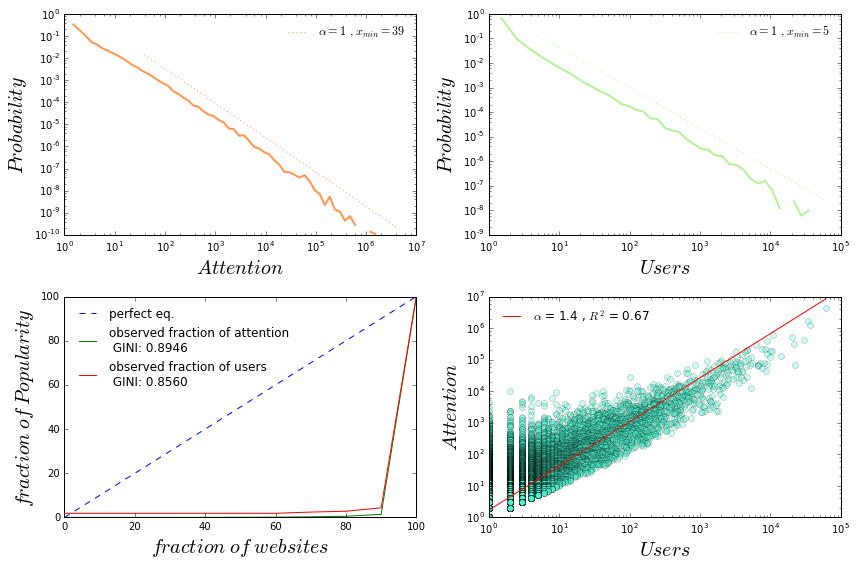

In [194]:
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow_r',6)

fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2, 2, 1)
plotPowerlaw(dfg, ax,cmap(1), '$Attention$')
ax = fig.add_subplot(2, 2, 2)
plotPowerlaw(dfg_user, ax,cmap(2), '$Users$')

ax = fig.add_subplot(2, 2, 3)

bins, result, gini_val = gini_coefficient(dfg)
# fig = plt.figure(figsize=(8, 8),facecolor='white')
plt.plot(bins, bins, '--', label="perfect eq.")
plt.plot(bins, result, label="observed fraction of attention \n GINI: %.4f" %(gini_val))

bins, result, gini_val = gini_coefficient(dfg_user)
plt.plot(bins, result, label="observed fraction of users \n GINI: %.4f" %(gini_val))
plt.xlabel("$fraction\; of\; websites$", fontsize = 20)
plt.ylabel("$fraction \;of \;Popularity$", fontsize = 20)

plt.legend(loc = 0, frameon = False)

ax = fig.add_subplot(2, 2, 4)
alloRegressPlot(user,time, cmap(3),'o','$Users$','$Attention$', loglog=True)

plt.tight_layout()


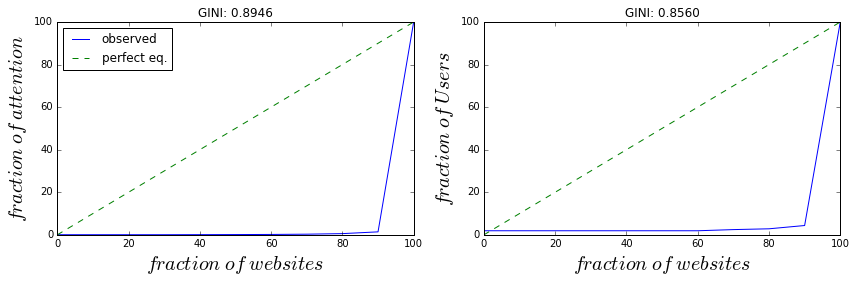

In [178]:

fig = plt.figure(figsize=(12, 4),facecolor='white')
ax = fig.add_subplot(1, 2, 1)

bins, result, gini_val = gini_coefficient(dfg)
# fig = plt.figure(figsize=(8, 8),facecolor='white')

plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("$fraction\; of\; websites$", fontsize = 20)
plt.ylabel("$fraction \;of \;attention$", fontsize = 20)
plt.title("GINI: %.4f" %(gini_val))
plt.legend(loc = 0)
ax = fig.add_subplot(1, 2, 2)

bins, result, gini_val = gini_coefficient(dfg_user)
# fig = plt.figure(figsize=(8, 8),facecolor='white')

plt.plot(bins, result, label="observed")
plt.plot(bins, bins, '--', label="perfect eq.")
plt.xlabel("$fraction\; of\; websites$", fontsize = 20)
plt.ylabel("$fraction \;of \;Users$", fontsize = 20)
plt.title("GINI: %.4f" %(gini_val))

plt.tight_layout()
plt.show()

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


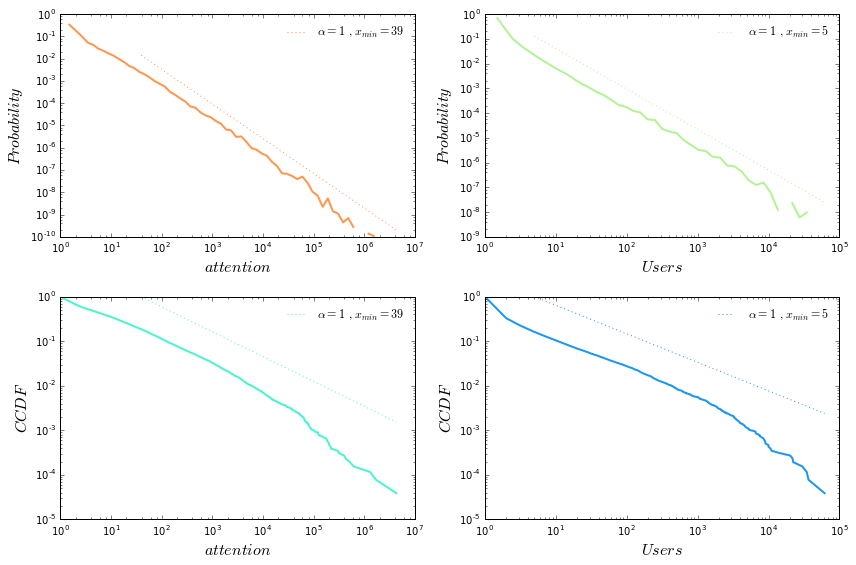

In [134]:
import matplotlib.cm as cm
cmap = cm.get_cmap('rainbow_r',6)

fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2, 2, 1)
plotPowerlaw(dfg, ax,cmap(1), '$attention$')
ax = fig.add_subplot(2, 2, 2)
plotPowerlaw(dfg_user, ax,cmap(2), '$Users$')
ax = fig.add_subplot(2, 2, 3)
plotCCDF(dfg, ax,cmap(3), '$attention$')
ax = fig.add_subplot(2, 2, 4)
plotCCDF(dfg_user, ax,cmap(4), '$Users$')
plt.tight_layout()


[-0.12090779732866871,
 -0.46384133608334566,
 -1.4496598284545296e-06,
 0.97996185174257988]

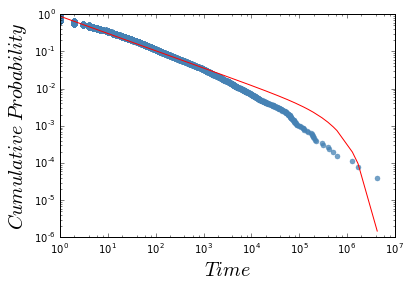

In [47]:
powerLawExponentialCutOffPlot(dfg, '$Time$', '$Cumulative \;Probability$')

[-0.51534363533299521,
 -0.72528884239681068,
 -1.9703589712294063e-05,
 0.91643432546728598]

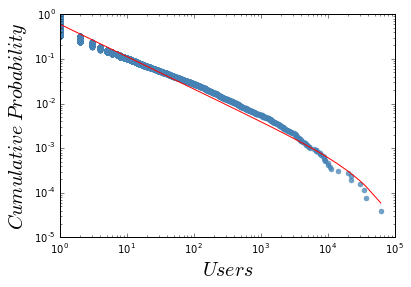

In [152]:
powerLawExponentialCutOffPlot(dfg_user, '$Users$', '$Cumulative \;Probability$')

[  3.68335134e-01   1.30876126e+00   3.93669047e+06]


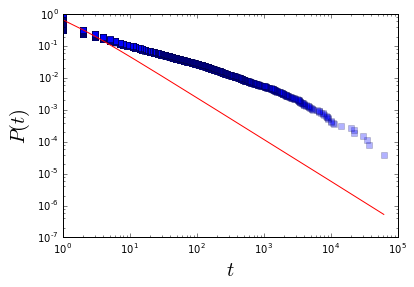

In [159]:
def func(x, x0, beta, K):
    return (x + x0) ** (-beta) * np.exp(-x/ K)

from scipy import optimize

# calculate P(rg)
data = dfg_user
# rg = sorted(data, reverse=True)
# rg = np.array(rg)
# prg = np.arange(len(rg)) / float(len(rg)-1)
x = np.array(sorted(data,key=lambda x:-x))
y = np.array(range(len(data))) +1
y = y/float(np.max(y))

popt, pcov = optimize.curve_fit(func, x, y)
print popt

plt.plot(x, y, 'bs', alpha = 0.3)
plt.plot(x, (x+popt[0])**-(popt[1])*np.exp(-x/popt[2]), 'r-' )
plt.yscale('log')
plt.xscale('log')
plt.xlabel('$t$', fontsize = 20)
plt.ylabel('$P(t)$', fontsize = 20)
plt.show()

# Constructing Flow Network

In [195]:
# functions for flow network analysis
import networkx as nx

def constructFlowNetwork (C):
    '''
    C is an array of two dimentions, e.g., 
    C = np.array([[user1, item1], 
                  [user1, item2], 
                  [user2, item1], 
                  [user2, item3]])
    '''
    E=defaultdict(lambda:0)
    E[('source',C[0][1])]+=1
    E[(C[-1][1],'sink')]+=1
    F=zip(C[:-1],C[1:])
    for i in F:
        if i[0][0]==i[1][0]:
            E[(i[0][1],i[1][1])]+=1
        else:
            E[(i[0][1],'sink')]+=1
            E[('source',i[1][1])]+=1
    G=nx.DiGraph()
    for i,j in E.items():
        x,y=i
        G.add_edge(x,y,weight=j)
    return G

def flowBalancing(G):
    H = G.copy()
    O = G.out_degree(weight='weight')
    I = G.reverse().out_degree(weight='weight')
    for i in O:
        if i =='sink' or i=='source':
            continue
        de = I[i]-O[i]
        if de > 0:
            H.add_edge(i,'sink',weight=de)
        elif de < 0:
            H.add_edge('source',i,weight=-de)
    return H


def networkDissipate(G):
    D=defaultdict(lambda:[0,0,0])#toSink,totalflow,fromSource
    for x,y in G.edges():
        w = G[x][y].values()[0]
        if y == 'sink':
            D[x][0]+=w
        if x != 'source':
            D[x][1]+=w
        elif x == 'source':
            D[y][2]+=w
    return D

In [198]:
df[:15]

,user,time,loc,website
1,35468103,20131201163608,39.65311_116.033488,qq.com
4,35468103,20131201163612,39.65311_116.033488,doubleclick.net
5,35468103,20131201163613,39.65311_116.033488,facebook.com
6,35468103,20131201163616,39.65311_116.033488,crashlytics.com
7,35468103,20131201163624,39.65311_116.033488,bmob.cn
8,35468103,20131201163625,39.65311_116.033488,ppstream.com
9,35468103,20131201163627,39.65311_116.033488,qq.com
10,35468103,20131201163629,39.65311_116.033488,duapp.com
14,35468103,20131201163630,39.65311_116.033488,qq.com
17,35468103,20131201163633,39.65311_116.033488,baidu.com


In [200]:
C = df[['user', 'website']]#[af_df['day']=='2016-10-01']
C = np.array(C)
g = constructFlowNetwork(C)

In [201]:
h = flowBalancing(g)
nx.info(h)

'Name: \nType: DiGraph\nNumber of nodes: 25753\nNumber of edges: 376118\nAverage in degree:  14.6048\nAverage out degree:  14.6048'

In [202]:
nx.info(g)

'Name: \nType: DiGraph\nNumber of nodes: 25753\nNumber of edges: 376118\nAverage in degree:  14.6048\nAverage out degree:  14.6048'

In [203]:
di = networkDissipate(g)

toSink,totalflow,fromSource = np.array(di.values()).T

toflow = totalflow-toSink
fromflow = totalflow - fromSource

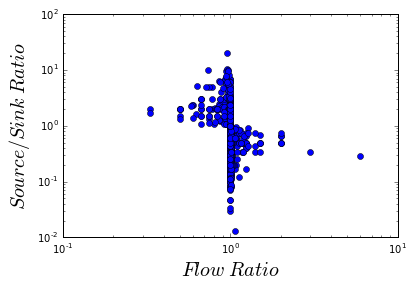

In [204]:
x = map(float, fromflow)/toflow 
y = map(float, fromSource)/toSink 
plt.plot(x, y, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$Flow\;Ratio$', fontsize = 20)
plt.ylabel('$Source/Sink\;Ratio$', fontsize = 20)
plt.show()

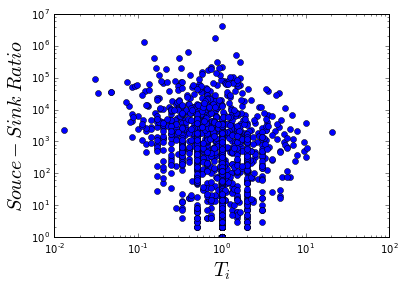

In [205]:
plt.plot(y, totalflow, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_i$', fontsize = 20)
plt.ylabel('$Souce-Sink\;Ratio$', fontsize = 20)
plt.show()

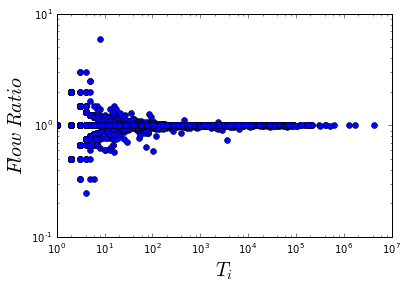

In [206]:
plt.plot(totalflow, x, 'o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$T_i$', fontsize = 20)
plt.ylabel('$Flow\;Ratio$', fontsize = 20)
plt.show()

In [208]:
def log_binning(x, y, bin_count=20):
    max_x = np.log10(max(x))
    max_y = np.log10(max(y))
    max_base = max([max_x,max_y])
    xx = [i for i in x if i>0]
    min_x = np.log10(np.min(xx))
    bins = np.logspace(min_x,max_base,num=bin_count)
    bin_means_y = (np.histogram(x,bins,weights=y)[0] / np.histogram(x,bins)[0])
    bin_means_x = (np.histogram(x,bins,weights=x)[0] / np.histogram(x,bins)[0])
    return bin_means_x,bin_means_y

def alloRegressPlot(xdata,ydata,col,mark,xlab,ylab, loglog):
    ti, di = log_binning(xdata,ydata)
    x=np.log(ti+0.1);y=np.log(di+0.1);
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant=res.params[0];beta=res.params[1]; r2=res.rsquared
    plt.plot(xdata,ydata,mark,color=col, alpha = 0.3)
    plt.plot(ti, di, 'ro')
    xs = np.linspace(min(ti+1),max(ti+1),100)
    plt.plot(xs,np.exp(constant)*xs**beta,color='r',linestyle='-', 
             label = '$\\gamma$ = '+ str(np.round(beta,2)) + ' , ' \
         + '$R^2$ = ' + str(np.round(r2,3)))
    plt.legend(loc = 0)
    if loglog == True:
        plt.xscale('log');plt.yscale('log')
    plt.xlabel(xlab, fontsize = 20);plt.ylabel(ylab, fontsize = 20)
    minx,maxx=plt.xlim(); miny,maxy=plt.ylim()


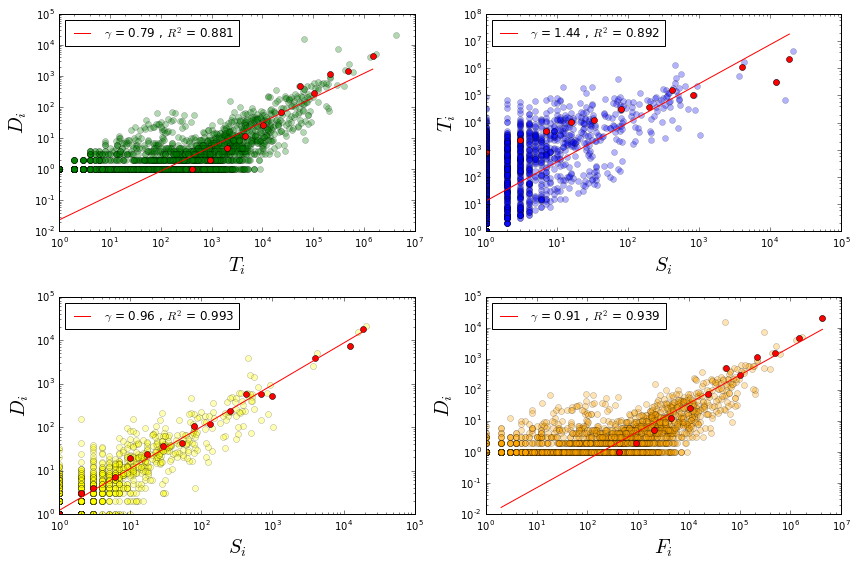

In [209]:
fig = plt.figure(figsize=(12, 8),facecolor='white')
ax = fig.add_subplot(2,2,1)
alloRegressPlot(totalflow,toSink,'g','o','$T_i$','$D_i$', True)
ax = fig.add_subplot(2,2,2)
alloRegressPlot(fromSource,totalflow,'b','o','$S_i$','$T_i$', True)
ax = fig.add_subplot(2,2,3)
alloRegressPlot(fromSource,toSink,'yellow','o','$S_i$','$D_i$', True)
ax = fig.add_subplot(2,2,4)
alloRegressPlot(toflow,toSink,'orange','o','$F_i$','$D_i$', True)
plt.tight_layout()


In [210]:
from scholarNetwork import scholarNetwork as sn

In [211]:
fd = sn.flowDistanceFromSource(g)

In [212]:
fd.items()[:3]

[(nan, 25.060488860866815),
 ('iseesoft.cn', 25.23419352228077),
 ('niijhsk.com', 26.476652743895336)]

In [247]:
dii = {}
for i in di:
    if i in dfg:
        dii[i]=[di[i][0], di[i][1], di[i][2], fd[i], dfg[i], dfg_user[i]]

In [248]:
dii.items()[:3]

[('iseesoft.cn', [0, 1, 0, 25.23419352228077, 1, 1]),
 ('niijhsk.com', [0, 1, 0, 26.476652743895336, 1, 1]),
 ('guomob.com', [12, 14042, 6, 25.720884643692923, 14042, 193])]

In [249]:
toSink,totalflow,fromSource, flowdistance, duration_i, uv_i = np.array(dii.values()).T
toflow = totalflow-toSink
fromflow = totalflow - fromSource

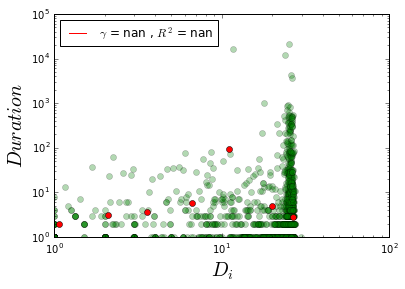

In [255]:
alloRegressPlot(flowdistance,fromSource,'g','o','$D_i$','$Duration$', True)

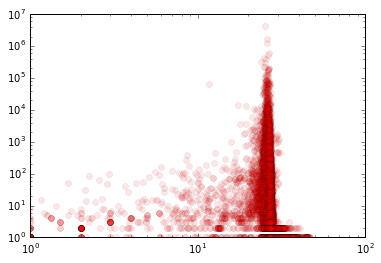

In [251]:
plt.plot(flowdistance, duration_i,'ro', alpha = .1)
plt.xscale('log')
plt.yscale('log')
plt.show()

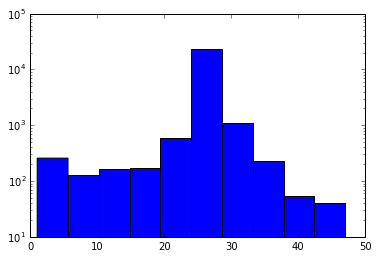

In [257]:
plt.hist(flowdistance)
plt.yscale('log')

# 引力定律